# Stable Fluids

Attempting to implement the method described in [this paper](https://pages.cs.wisc.edu/~chaol/data/cs777/stam-stable_fluids.pdf).

First let's do some importing.

In [130]:
import cv2
import scipy.stats.qmc as qmc
import scipy
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from collections import Counter
import random
from manim import *
import scipy.stats.qmc as qmc
import os

## 1: Hyperparameter and setup methods

Next we need som setup methods. These provide a basis for creating/importing a UV field etc.

In [131]:
def import_UV_from_file(file_U, file_V):
    with open(file_U, 'rb') as inp:
        U = np.real(pickle.load(inp))
    with open(file_V, 'rb') as inp:
        V = np.real(pickle.load(inp))

def generate_random_UV(sz):
    U = np.random.random(sz)
    V = np.random.random(sz)

def generate_UV_training(sz):
    U = np.zeros(sz)
    V = np.zeros(sz)

    x_ordinates = np.arange(sz[1])
    y_ordinates = np.arange(sz[0])
    #Create a meshgrid
    X, Y = np.meshgrid(x_ordinates, y_ordinates)
    r1 = np.random.randint(0,sz[0])
    r2 = np.random.randint(0,sz[1])
    r3 = np.random.randint(0,sz[0])
    r4 = np.random.randint(0,sz[1])
    R1 = np.sqrt((X-r1)**2+(Y-r2)**2)
    R2 = np.sqrt((X-r3)**2+(Y-r4)**2)
    U = np.exp(-R1/50) + np.exp(-R2/50)
    V = np.exp(-R1/50) + np.exp(-R2/50)

    return U,V

def get_coordinates():
    #Get the coordinates of the fluid
    x_ordinates = np.arange(sz[1])/sz[1]
    y_ordinates = np.arange(sz[0])/sz[0]/ar
    #Create a meshgrid
    X, Y = np.meshgrid(x_ordinates, y_ordinates)
    return X,Y

sz = np.array([520,520])
U,V = generate_UV_training(sz)
X, Y = get_coordinates()

Hyperparameters

In [132]:
#General parameters
ar = sz[1]/sz[0]
width = 1.0 # Size in units
w_el = width/sz[1]

#Fluid parameters
kinematic_viscosity = 0.0001

#Simulation parameters
dt = 0.1

Now we need to define some mathematical methods. Namely the partial derivative wrt x and y.

In [133]:
def du_dy(U):
    #Get the derivative of U in the y direction with continuous boundary conditions
    U_plusdh = np.roll(U,1,axis=0) #Pushes the array along in the y direction by 1 item
    U_minusdh = np.roll(U,-1,axis=0) #Pushes the array along in the y directions by -1 item
    dU_dy = (U_plusdh-U_minusdh)/(2*w_el) #Takes derivative
    return dU_dy
def dv_dx(V):
    #Get the derivative of V in the x direction with continuous boundary conditions
    V_plusdh = np.roll(V,1,axis=1)
    V_minusdh = np.roll(V,-1,axis=1)
    dV_dx = (V_plusdh-V_minusdh)/(2*w_el)
    return dV_dx

def nabla_squared(V):
    V_11 = np.roll(V,1,axis=1)
    V_10 = np.roll(V,-1,axis=1)
    V_01 = np.roll(V,1,axis=0)
    V_00 = np.roll(V,-1,axis=0)
    return -(V_11+V_10+V_01+V_00-4*V)/(w_el**2)


def vorticity(U,V):
    #Get the vorticity of the fluid
    dU_dy = du_dy(U)
    dV_dx = dv_dx(V)
    omega = dU_dy-dV_dx
    return omega


## Step Whatever: Stable Fluids Methods

Next we will define advect. This is the method which will track particles back along their streamlines and track their value.

In [134]:
def advect(velocity_x_prev, velocity_y_prev):
  velocity_x_prev = np.copy(velocity_x_prev)
  velocity_y_prev = np.copy(velocity_y_prev)
  nx = np.shape(X)[1]
  ny = np.shape(X)[0]
  #First, get the backtraced coordinates (if you follow the streamline
  #back, where do we go?)
  backtraced_coordinates_x = X - dt * velocity_x_prev
  backtraced_coordinates_y = Y - dt * velocity_y_prev

  #The reference tells us the matrix index of the matrix we need to select
  backtraced_reference_x = backtraced_coordinates_x / ar * nx
  backtraced_reference_x_low = np.floor(backtraced_reference_x)
  backtraced_reference_x_high = np.ceil(backtraced_reference_x)
  linear_const_x = backtraced_reference_x - backtraced_reference_x_low
  
  # backtraced_reference_x_low = np.clip(backtraced_reference_x_low, 0, nx-1)
  # backtraced_reference_x_high = np.clip(backtraced_reference_x_high, 0, nx-1)
  backtraced_reference_x_low = backtraced_reference_x_low % nx
  backtraced_reference_x_high = backtraced_reference_x_high % ny

  backtraced_reference_y = backtraced_coordinates_y * ny
  backtraced_reference_y_low = np.floor(backtraced_reference_y)
  backtraced_reference_y_high = np.ceil(backtraced_reference_y)
  linear_const_y = backtraced_reference_y - backtraced_reference_y_low

  # backtraced_reference_y_low = np.clip(backtraced_reference_y_low, 0, ny-1)
  # backtraced_reference_y_high = np.clip(backtraced_reference_y_high, 0, ny-1)

  backtraced_reference_y_low = backtraced_reference_y_low % ny
  backtraced_reference_y_high = backtraced_reference_y_high % ny

  #Need to reshape the velocity matrix to account for the fact that we can
  #only index a vector not a matrix
  velocity_x_row = np.reshape(velocity_x_prev,[np.size(velocity_x_prev)])
  velocity_y_row = np.reshape(velocity_y_prev,[np.size(velocity_y_prev)])

  #Need to amend the referencing to account for the fact it is a vector not
  #a matrix.
  low_low_index = np.int32((backtraced_reference_x_low)+(backtraced_reference_y_low)*nx)
  low_high_index = np.int32((backtraced_reference_x_low)+(backtraced_reference_y_high)*nx)
  high_low_index = np.int32((backtraced_reference_x_high)+(backtraced_reference_y_low)*nx)
  high_high_index = np.int32((backtraced_reference_x_high)+(backtraced_reference_y_high)*nx)

  #Complete interpolation for backtracing
  velocity_x = velocity_x_row[low_low_index]* (1-linear_const_x)*(1-linear_const_y) + velocity_x_row[low_high_index]* (1-linear_const_x)*(linear_const_y) + velocity_x_row[high_low_index]* (linear_const_x)*(1-linear_const_y) + velocity_x_row[high_high_index]* (linear_const_x)*(linear_const_y)
  velocity_y = velocity_y_row[low_low_index]* (1-linear_const_x)*(1-linear_const_y) + velocity_y_row[low_high_index]* (1-linear_const_x)*(linear_const_y) + velocity_y_row[high_low_index]* (linear_const_x)*(1-linear_const_y) + velocity_y_row[high_high_index]* (linear_const_x)*(linear_const_y)

  return (velocity_x, velocity_y)

Next, diffusion accounts for viscosity

In [135]:
def diffuse(velocity_x_prev, velocity_y_prev):
  #Diffuse the fluid
  nabla_squared_x = nabla_squared(velocity_x_prev)
  nabla_squared_y = nabla_squared(velocity_y_prev)
  velocity_x = velocity_x_prev - dt * nabla_squared_x *kinematic_viscosity
  velocity_y = velocity_y_prev - dt * nabla_squared_y *kinematic_viscosity
  velocity_x = velocity_x_prev
  return (velocity_x, velocity_y)

In [136]:
def project(velocity_x_prev, velocity_y_prev):
    

SyntaxError: incomplete input (3059019623.py, line 2)

## Step Whatever: Implementation Over Time
This is a placeholder for now.

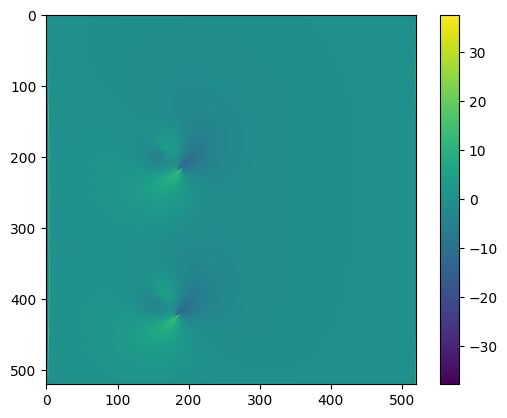

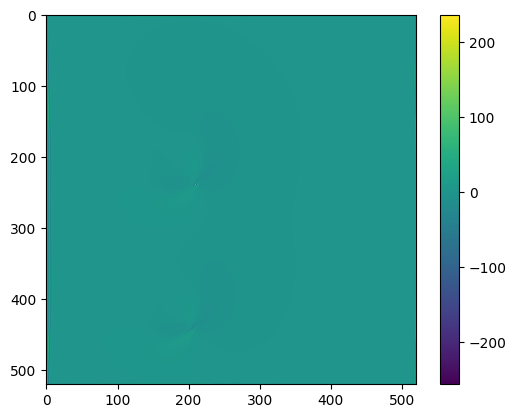

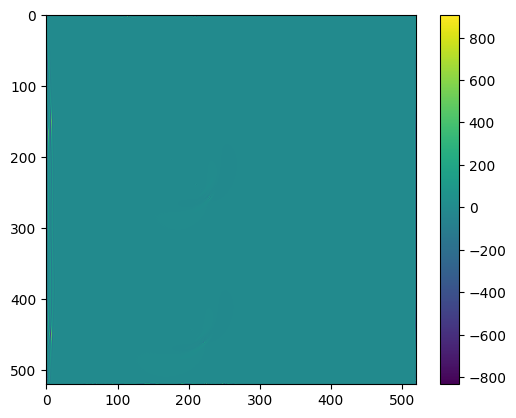

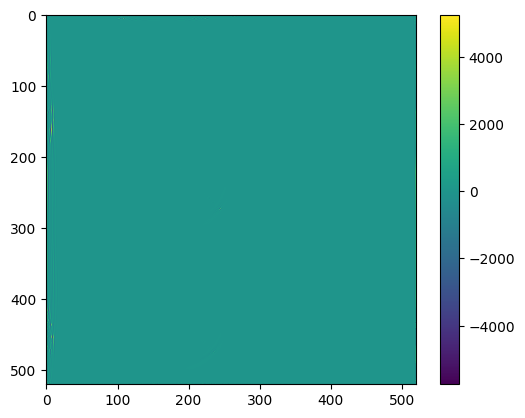

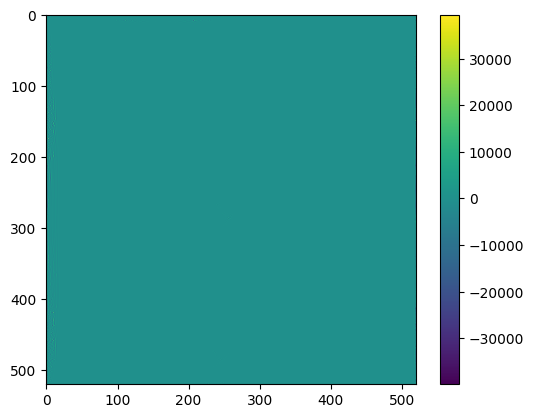

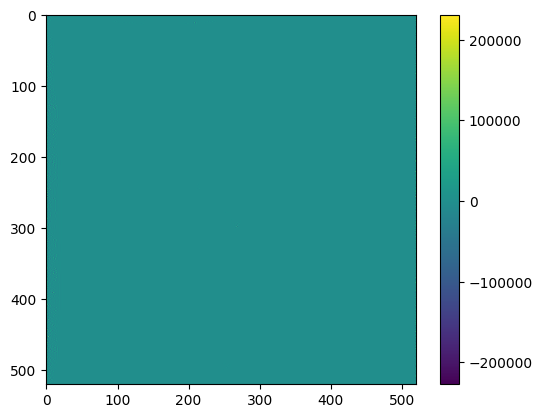

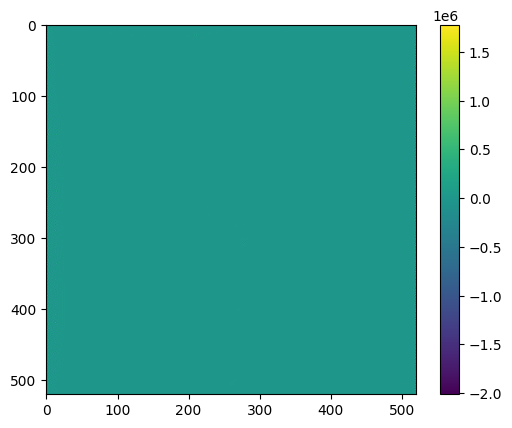

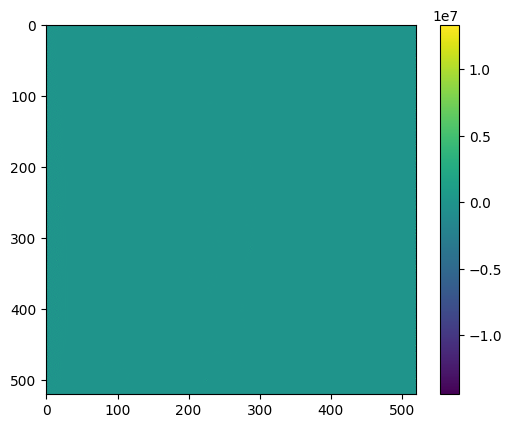

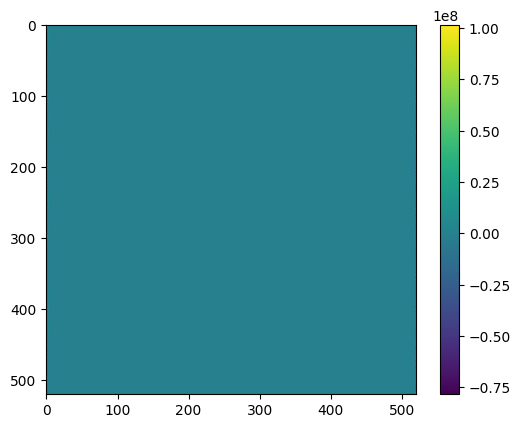

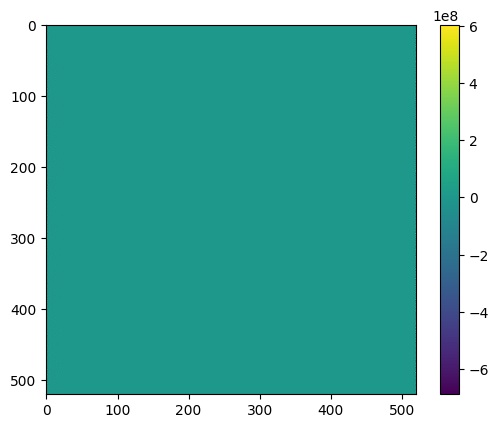

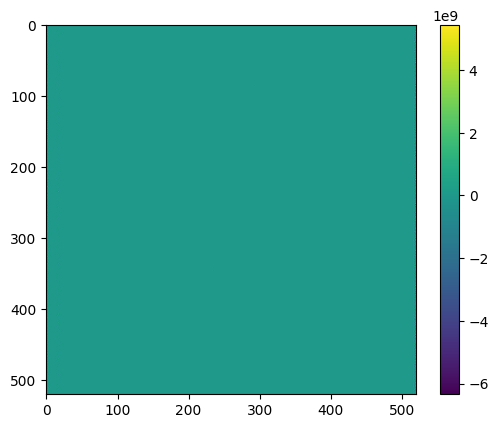

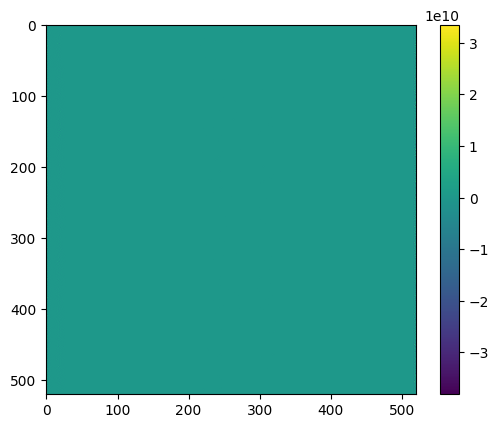

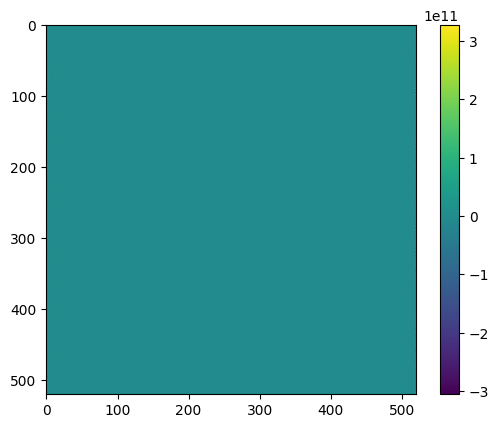

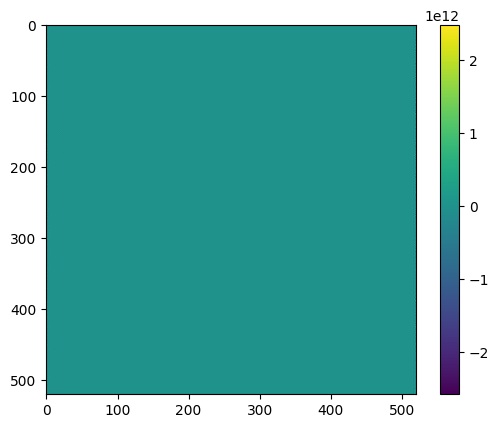

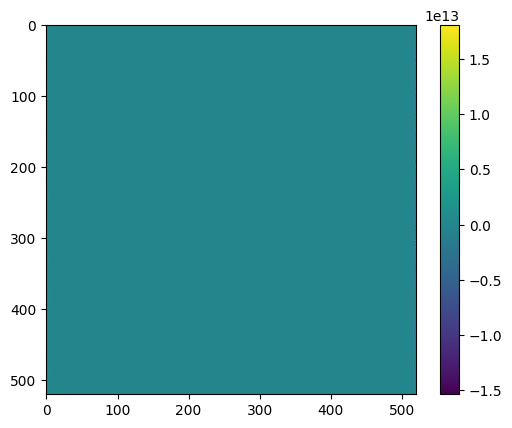

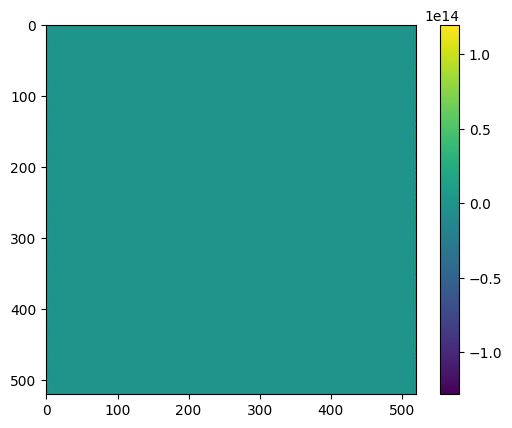

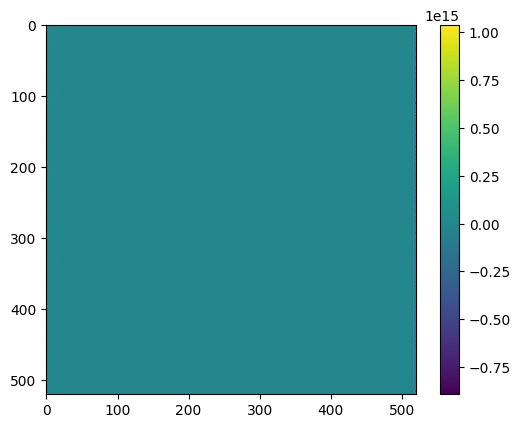

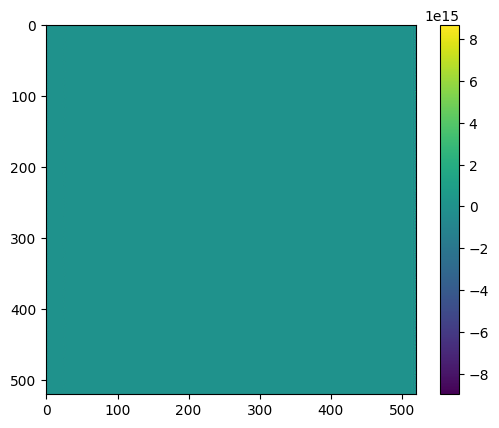

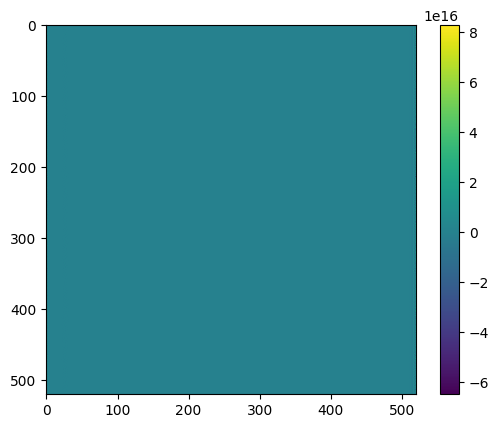

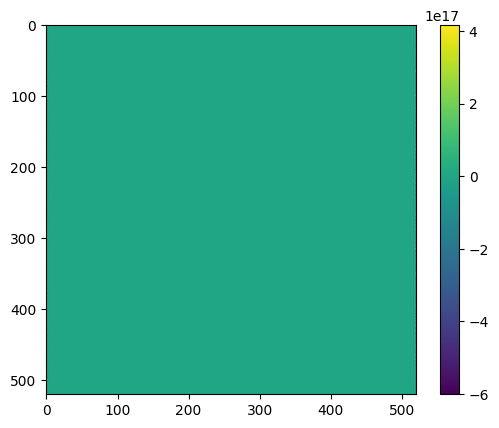

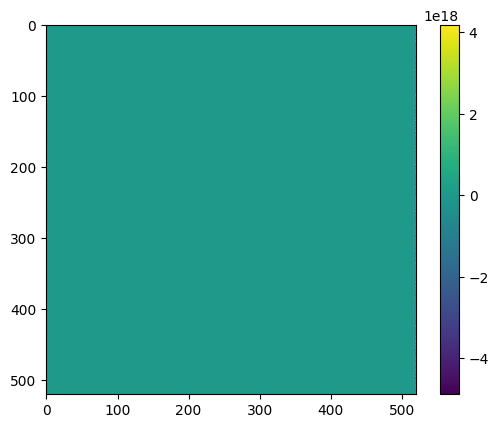

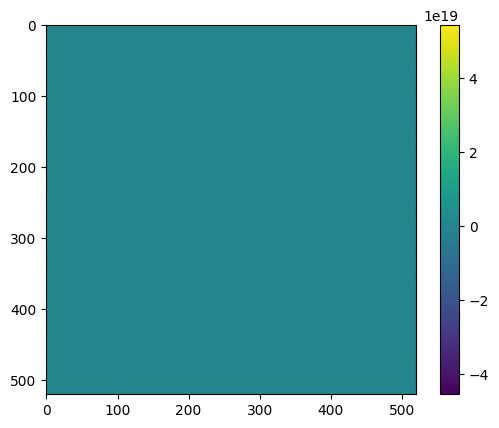

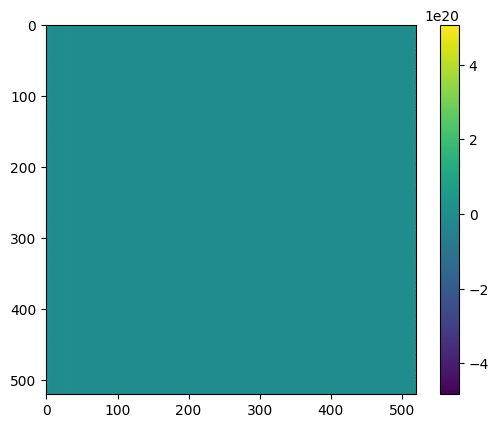

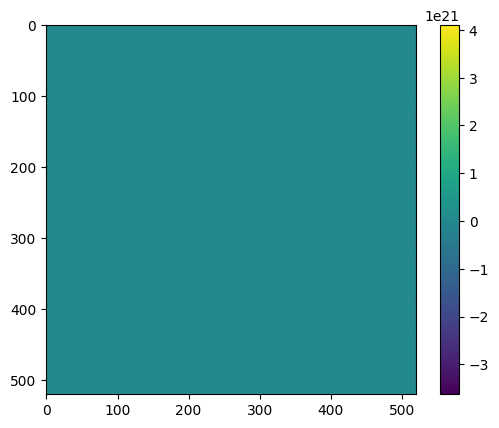

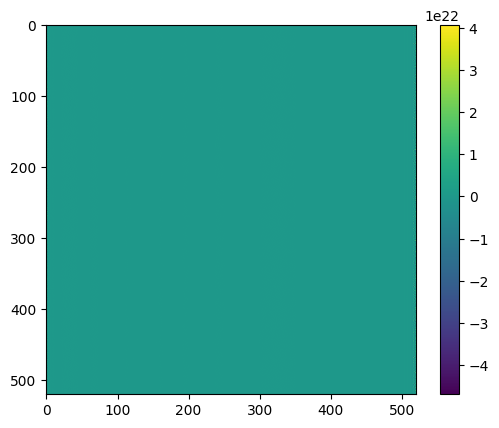

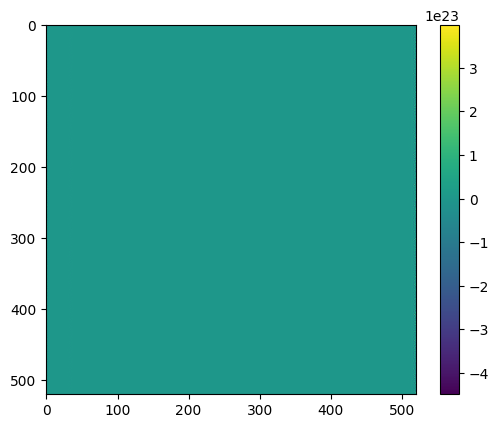

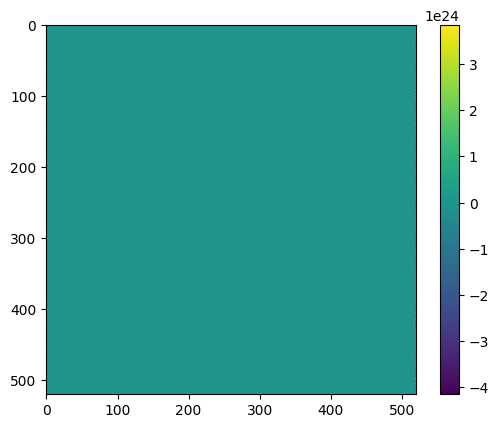

KeyboardInterrupt: 

In [ ]:
for i in range(100):
    U,V = advect(U,V)
    U, V = diffuse(U,V)
    U, V = project(U,V)
    plt.imshow(vorticity(U,V))
    plt.colorbar()
    plt.show()